In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression

from scipy.special import expit
from scipy.stats import norm

In [11]:
def simulate(**kwargs):
  values = {}
  for k,v in kwargs.items():
    parents = v.__code__.co_varnames
    inputs = {arg: values[arg] for arg in parents}
    values[k] = v(**inputs)
  return pd.DataFrame(values)

In [108]:
N = 1000
df = simulate(
    X = lambda: np.random.uniform(-1, 1, N),
    T = lambda X: np.random.normal(X, 1),
    Y = lambda X,T: np.random.normal(T - 8*X)
)

# Generalized Propensity Scores

,coef,std err,t,P>|t|,[0.025,0.975]
T,-0.9876,0.113,-8.718,0.000,-1.210,-0.765


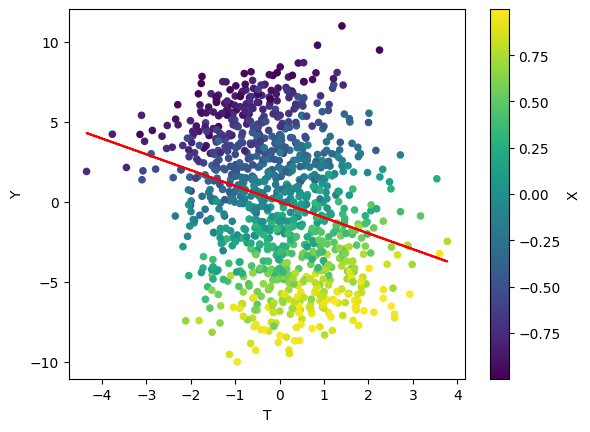

In [109]:
fig, ax = plt.subplots()
ols = sm.OLS(df['Y'], df['T']).fit()
predictions = ols.fittedvalues
df.plot.scatter(x='T', y='Y', color='X', ax=ax);
ax.plot(df['T'], predictions, color='red');
ols.summary().tables[1]

In [110]:
gps_model = smf.ols('T ~ X', data=df).fit()
# What treatment do we predict for this user?
df['T_pred'] = gps_model.fittedvalues
# What is the probability of receiving the actual treatment, if the treatment is normally distributed around the predicted treatment?
df['gps']        = norm(loc=df['T_pred'],   scale=np.std(df['T'] - df['T_pred'])).pdf(df['T'])
# What is the probability of getting this value of treatment, not conditioned on X
df['normalizer'] = norm(loc=df['T'].mean(), scale=np.std(df['T'] - df['T'].mean())).pdf(df['T'])
df['w'] = 1/df['gps']
df['w_norm'] = df['normalizer'] / df['gps']

,coef,std err,t,P>|t|,[0.025,0.975]
T,-0.0716,0.051,-1.412,0.158,-0.171,0.028


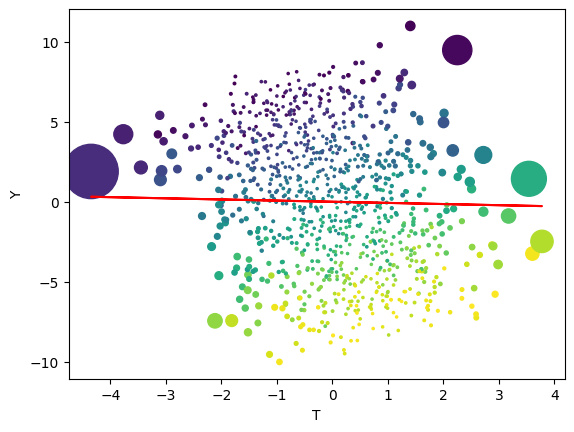

In [111]:
fig, ax = plt.subplots()
wls = sm.WLS(df['Y'], df['T'], weights=df['w']).fit()
predictions = wls.fittedvalues
df.plot.scatter(x='T', y='Y', s=df['w'], color=df['X'], ax=ax);
ax.plot(df['T'], predictions, color='red');
wls.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
T,1.0066,0.133,7.594,0.000,0.747,1.267


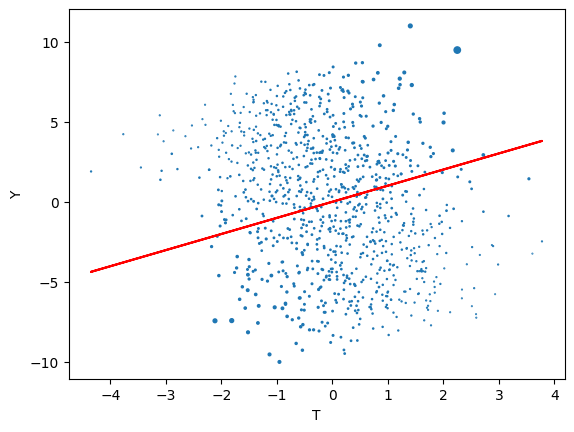

In [112]:
fig, ax = plt.subplots()
wls = sm.WLS(df['Y'], df['T'], weights=df['w_norm']).fit()
predictions = wls.fittedvalues
df.plot.scatter(x='T', y='Y', s=df['w_norm'], ax=ax);
ax.plot(df['T'], predictions, color='red');
wls.summary().tables[1]

# Debiased / FWL Orthogonalization
## This idea behind Double ML

In [114]:
treatment_model = smf.ols('T ~ X', data=df).fit()
outcome_model = smf.ols('Y ~ X', data=df).fit()

df['T_resid'] = df['T'] - treatment_model.fittedvalues
df['Y_resid'] = df['Y'] - outcome_model.fittedvalues

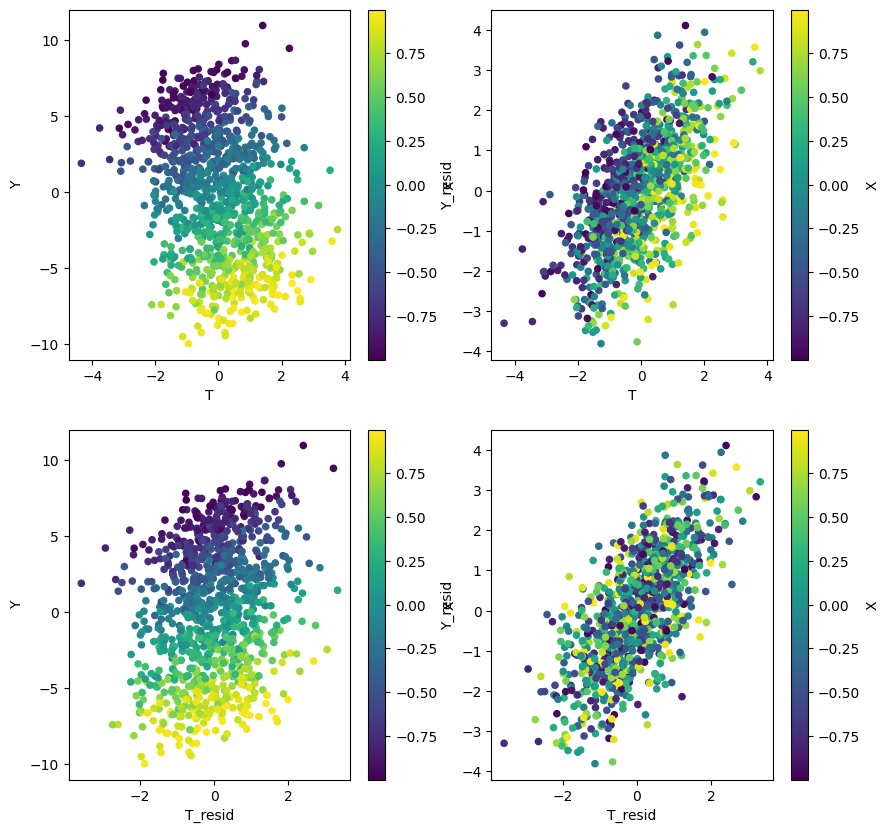

In [122]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
df.plot.scatter(x='T', y='Y', color='X', ax=ax[0,0]);
df.plot.scatter(x='T', y='Y_resid', color='X', ax=ax[0,1]);
df.plot.scatter(x='T_resid', y='Y', color='X', ax=ax[1,0]);
df.plot.scatter(x='T_resid', y='Y_resid', color='X', ax=ax[1,1]);

In [123]:
smf.ols('Y_resid ~ T_resid', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.082e-17,0.032,6.46e-16,1.000,-0.063,0.063
T_resid,0.9757,0.032,30.286,0.000,0.912,1.039
